# **Forecasting New York College Tuition Prices**

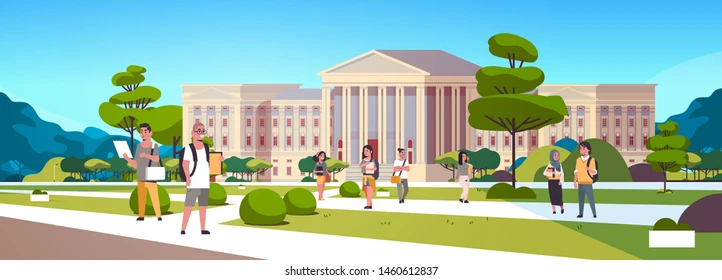

**BIDSS Final Project** <br>
>New York college tuition is steadily increasing while funds for the Tuition Assistance Program (TAP) remain static.

>**Questions to explore:**


1.   What has been the trend in tuition aid for the past years?
2.   What has been the trend in tuition prices for the past years?
3.   What is the forecast for tuition prices for future years?



# **PIP installs and imports**
Run this cell to setup the coding environment.

In [ ]:
!pip install sodapy sktime pmdarima
import requests
import json
from bs4 import  BeautifulSoup
import pandas as pd
import numpy as np
from sodapy import Socrata
import matplotlib.pyplot as plt
from matplotlib import cm
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.arima import AutoARIMA
from sktime.utils.plotting import plot_series
import warnings
warnings.filterwarnings("ignore")

# **Using API to pull data from source**
The following cell will request the Tuition Assistance Program data and create a visualization that shows the number of TAP recipients have lowered from 2009 to 2010 and have remained static since then. The drop from 2009 to 2010 was due to state-wide budget cuts.

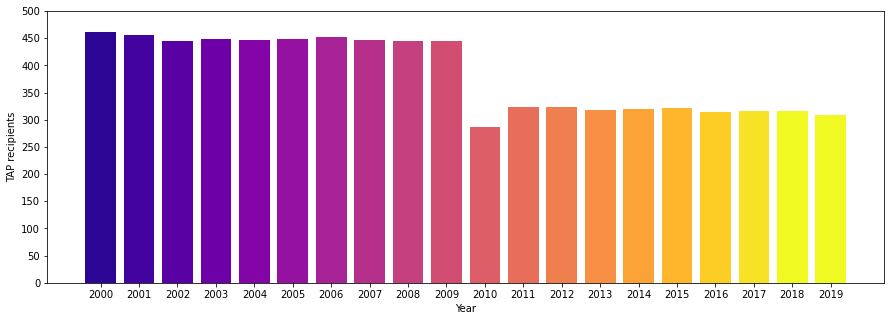

In [ ]:
client = Socrata("data.ny.gov", None)
results = client.get("tua9-wsak", limit=8000)
results_df = pd.DataFrame.from_records(results)
results_df.to_csv('TAP.csv', index=False)
df = pd.read_csv('TAP.csv')

year_counts = df['academic_year'].value_counts().sort_index()
ycr = year_counts.reset_index()
year_counts = ycr.rename(columns={'index':'year', 'academic_year':'counts'})

cl = list(range(1, 21))
cmp = plt.cm.get_cmap('plasma', 20)
colors = cmp(cl)
plt.figure(figsize=(15,5))
plt.xticks(year_counts['year'])
plt.ylim([0, 500])
plt.yticks(np.arange(0, 501, 50))
plt.xlabel('Year')
plt.ylabel('TAP recipients')
plt.bar(year_counts['year'], year_counts['counts'], color=colors)
plt.show()

# **Web Scrapping**
Tuition data from the top 15 colleges that provide TAP will be scraped from the web and used to forecast future tuition prices.

In [ ]:
college_names = ["MORRISVILLE STATE COLLEGE", "SUNY COBLESKILL", "SUNY COLLEGE OF TECH AT ALFRED", "SUNY COLLEGE OF TECH AT CANTON",
                 "SUNY COLLEGE OF TECH AT DELHI", "SUNY COLLEGE OF TECH FARMINGDALE", "COLUMBIA UNIV", "TROCAIRE COLLEGE",
                 "SYRACUSE UNIVERSITY UTICA COLLEGE", 
                 "LONG ISLAND UNIVERSITY", "CONCORDIA COLLEGE", "NEW YORK SCHOOL INTERIOR DESIGN",
                 "ROCHESTER INST TECH 4YR UNDERGRAD", "ALFRED UNIVERSITY 4YR UNDERGRAD", "ADELPHI UNIVERSITY 4 YR UNDERGRAD"]



college_id = [2895, 2892, 126, 2891, 2893, 2894, 3853, 1404, 1269, 1433, 1340, 2133, 4105, 3220, 1392]
appended_data = []
for i in range(0, len(college_id)):
  url = f'https://api.chronicle.com/dl/q/bo/public/format/jsonp/name/cb_tuition_2020//order/year_pub:asc/fields/year_pub%7Ctuition_and_fees_in_state%7Ctuition_and_fees_out_of_state%7Croom_and_board%7Csector/find/hide:0:eq%7Corgid:{college_id[i]}:eq/callback/chegTableLive1CB?callback=chegTableLive1CB'
  page = requests.get(url)
  soup = BeautifulSoup(page.content, "html.parser")
  tuit = str(soup).replace('chegTableLive1CB', '')
  tuit_dict = tuit[1:-1]
  data = json.loads(tuit_dict)
  tuition_data = pd.DataFrame(data)
  tuition_data['college_name'] = college_names[i]
  appended_data.append(tuition_data)



appended_data = pd.concat(appended_data, ignore_index=True)
appended_data.to_csv('top15_data.csv', index=False)
# Data is saved to CSV to avoid sending repeated requests to pages

# **Machine Learning and forecasting**

In [ ]:
top15_data = pd.read_csv('top15_data.csv')
top15_data = top15_data.loc[:, ['year_pub',	'college_name', 'tuition_and_fees_in_state', 'tuition_and_fees_out_of_state']]
recent = top15_data[top15_data['year_pub'] > 2005]
recent = recent.sort_values(by=['college_name'])
name = list(recent['college_name'].unique())

**Sample of prediction of future prices using the ARIMA model**

**Forecast example**

Choose a college to forecast tuition prices. The model will forecast 5 years ahead.

1. ADELPHI UNIVERSITY 4 YR UNDERGRAD
2.  ALFRED UNIVERSITY 4YR UNDERGRAD
3. COLUMBIA UNIV
4. CONCORDIA COLLEGE
5. LONG ISLAND UNIVERSITY
6. MORRISVILLE STATE COLLEGE
7.  NEW YORK SCHOOL INTERIOR DESIGN
8.  ROCHESTER INST TECH 4YR UNDERGRAD
9.  SUNY COBLESKILL
10.  SUNY COLLEGE OF TECH AT ALFRED
11.  SUNY COLLEGE OF TECH AT CANTON
12.  SUNY COLLEGE OF TECH AT DELHI
13.  SUNY COLLEGE OF TECH FARMINGDALE
14.  SYRACUSE UNIVERSITY UTICA COLLEGE
15.  TROCAIRE COLLEGE

Choose a number from the list of college names to forecast:9


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0f78a40050>)

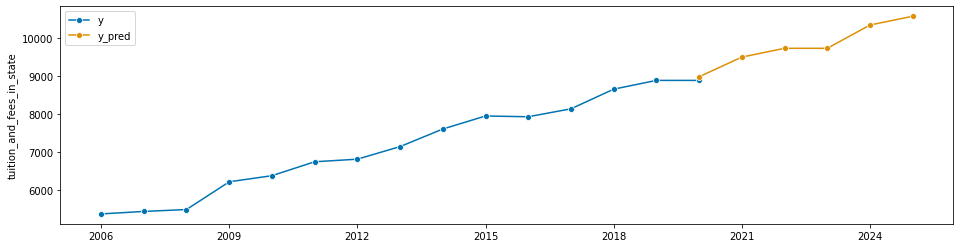

In [ ]:
option = int(input('Choose a number from the list of college names to forecast:')) - 1
data = recent[recent["college_name"].str.contains(name[option])].drop(['tuition_and_fees_out_of_state'], axis=1).sort_values(by=['year_pub'])
data = data.reset_index(drop=True)
data.set_index(['year_pub'], inplace=True)
needs_series = data.drop(['college_name'], axis=1)
series = needs_series.squeeze()
fh = np.arange(0, 6)
forecaster = AutoARIMA(sp=3, suppress_warnings=True)
forecaster.fit(series)
y_pred = forecaster.predict(fh)
plot_series(series, y_pred, labels=["y", "y_pred"])

**Creating Dataframe of forecasts for the top 15 TAP colleges**

In [ ]:
college_name = recent['college_name'].unique()
forecasted_values = []
for i in range(0, len(college_name)):
  data = recent[recent["college_name"].str.contains(college_name[i])].drop(['tuition_and_fees_out_of_state'], axis=1).sort_values(by=['year_pub'])
  data = data.reset_index(drop=True)
  data.set_index(['year_pub'], inplace=True)
  needs_series = data.drop(['college_name'], axis=1)
  series = needs_series.squeeze()
  fh = np.arange(0, 6)
  forecaster = AutoARIMA(sp=3, suppress_warnings=True, error_action="ignore")
  forecaster.fit(series)
  y_pred = forecaster.predict(fh)
  tuition_forecast = pd.DataFrame(y_pred, columns=['forecast'])
  tuition_forecast['college_name'] = college_name[i]
  forecasted_values.append(tuition_forecast)

forecasted_values = pd.concat(forecasted_values, ignore_index=True)

full = []
for name in college_name:
  one = forecasted_values[forecasted_values['college_name'] == name]
  one['year'] = np.arange(2020, 2026)
  full.append(one)

full = pd.concat(full, ignore_index=True)
full['forecast'] = round(full['forecast'])
full['forecast'] = full['forecast'].astype(int)
forecast = full
forecast.to_csv('forecast.csv', index=False)
pd.set_option('display.max_rows', None)
forecast

,forecast,college_name,year
0,34377,ADELPHI UNIVERSITY 4 YR UNDERGRAD,2020
1,35596,ADELPHI UNIVERSITY 4 YR UNDERGRAD,2021
2,36458,ADELPHI UNIVERSITY 4 YR UNDERGRAD,2022
3,37418,ADELPHI UNIVERSITY 4 YR UNDERGRAD,2023
4,38364,ADELPHI UNIVERSITY 4 YR UNDERGRAD,2024
5,39226,ADELPHI UNIVERSITY 4 YR UNDERGRAD,2025
6,35881,ALFRED UNIVERSITY 4YR UNDERGRAD,2020
7,37477,ALFRED UNIVERSITY 4YR UNDERGRAD,2021
8,38552,ALFRED UNIVERSITY 4YR UNDERGRAD,2022
9,39577,ALFRED UNIVERSITY 4YR UNDERGRAD,2023


Choose a college to visualize forecasted tuition prices.

1. ADELPHI UNIVERSITY 4 YR UNDERGRAD
2.  ALFRED UNIVERSITY 4YR UNDERGRAD
3. COLUMBIA UNIV
4. CONCORDIA COLLEGE
5. LONG ISLAND UNIVERSITY
6. MORRISVILLE STATE COLLEGE
7.  NEW YORK SCHOOL INTERIOR DESIGN
8.  ROCHESTER INST TECH 4YR UNDERGRAD
9.  SUNY COBLESKILL
10.  SUNY COLLEGE OF TECH AT ALFRED
11.  SUNY COLLEGE OF TECH AT CANTON
12.  SUNY COLLEGE OF TECH AT DELHI
13.  SUNY COLLEGE OF TECH FARMINGDALE
14.  SYRACUSE UNIVERSITY UTICA COLLEGE
15.  TROCAIRE COLLEGE

Choose a number from the list of college names to forecast:2


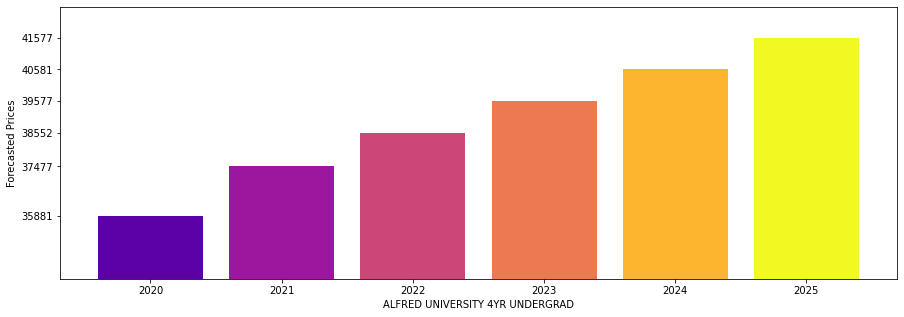

In [ ]:
college_names = sorted(college_names)
option = int(input('Choose a number from the list of college names to forecast:')) - 1

to_bar = forecast[forecast["college_name"].str.contains(sorted(college_names)[option])]
y = to_bar['forecast']
x = to_bar['year']
cl = list(range(1, 7))
cmp = plt.cm.get_cmap('plasma', 7)
colors = cmp(cl)
plt.figure(figsize=(15,5))
plt.xticks(to_bar['year'])
plt.yticks(to_bar['forecast'])
plt.ylim([min(y)-2000, max(y)+1000])
plt.xlabel(college_names[option])
plt.ylabel('Forecasted Prices')
plt.bar(x, y, color=colors)
plt.show()